In [2]:
# Load libraries 
import os
import faiss
import numpy as np
import pandas as pd 
from time import time
import seaborn as sns
from typing import Union
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [3]:
# Set visualisation style
plt.style.use("ggplot")

In [4]:
# Load pretrained model 
model = SentenceTransformer("msmarco-MiniLM-L-6-v3")

In [5]:
# Define required columns
required_column = ['Nama Produk / Rincian', 'Kode KBLI', 'Jenis Produk']

In [9]:
# Load training dataset - v3
data_train = pd.read_excel("../dataset/v3/kbli_prediksi_jenis_training_set_v2.xlsx", usecols = required_column)
data_test = pd.read_excel("../dataset/v3/kbli_prediksi_jenis_testing_set_v2.xlsx", usecols = required_column)

In [10]:
# Clean KBLI and Jenis Produk
data_train[data_train['Kode KBLI'].apply(lambda x: len(str(x).split(",")) > 1 or len(str(x).strip()) == 0)]

,Jenis Produk,Nama Produk / Rincian,Kode KBLI


In [11]:
data_train[data_train['Kode KBLI'].apply(lambda x: len(str(x).split(",")) > 1 or len(str(x).strip()) == 0)].to_dict("records")

[]

In [12]:
# Validate Kode KBLI
data_train[data_train['Kode KBLI'].apply(lambda x: len(str(x).split(",")) > 1)]

,Jenis Produk,Nama Produk / Rincian,Kode KBLI


In [13]:
# Convert Kode KBLI into "int"
data_train['Kode KBLI'] = data_train['Kode KBLI'].astype(int)

In [14]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Jenis Produk           1112 non-null   object
 1   Nama Produk / Rincian  1112 non-null   object
 2   Kode KBLI              1112 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 21.8+ KB


In [15]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Jenis Produk           278 non-null    object
 1   Nama Produk / Rincian  278 non-null    object
 2   Kode KBLI              278 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 6.6+ KB


In [16]:
# Concat dataset and remove duplicate
data_train = pd.concat([data_train, data_test]).drop_duplicates().reset_index()

In [17]:
# Create training dataset into hashmaps
data_train_maps = data_train.to_dict("records")

In [18]:
# Overview dataset
data_train.head()

,index,Jenis Produk,Nama Produk / Rincian,Kode KBLI
0,0,Bahan tambahan pangan,Kalium hidrogen tartrat,20119
1,1,"Ikan dan produk perikanan, termasuk moluska,...",Ikan presto,10212
2,2,Daging dan produk olahan daging,Daging kering unggas atau mamalia,10130
3,3,Susu dan analognya,Keju olahan berperisa,10590
4,4,Pangan olahan untuk keperluan gizi khusus,Pangan olahan diet khusus untuk mengontro...,10799


In [19]:
# Check dimension
data_train.shape

(1390, 4)

In [20]:
# Overview missing values
data_train.isna().sum()

index                    0
Jenis Produk             0
Nama Produk / Rincian    0
Kode KBLI                0
dtype: int64

In [21]:
# Overview Sentence Length
sentence_length = data_train['Nama Produk / Rincian'].apply(
    lambda sentence: len(sentence.split())
).tolist()
max_sentence_length = np.round(np.mean(sentence_length) + np.std(sentence_length)).astype("int")

C:\Users\alif\anaconda3\envs\test\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


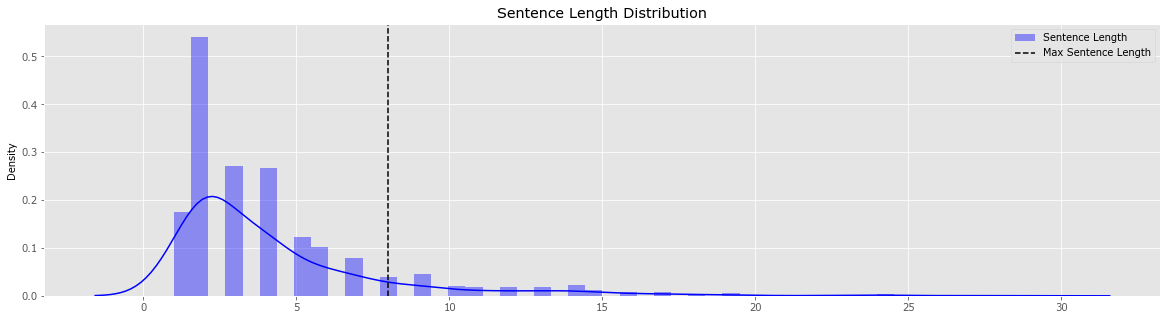

In [23]:
# Visualize density of sentence length distribution
plt.figure(figsize = (20, 5))
sns.distplot(sentence_length, hist = True, kde = True, color = "blue", label = "Sentence Length")
plt.axvline(x = max_sentence_length, color = "k", linestyle = "--", label = "Max Sentence Length")
plt.title("Sentence Length Distribution")
plt.legend()
plt.show()

In [24]:
# Convert Embedding
encoded_sentence = model.encode(data_train['Nama Produk / Rincian'].tolist(), show_progress_bar = True)
encoded_sentence = np.asarray(encoded_sentence.astype("float16"))

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

In [25]:
# Check dimension
encoded_sentence.shape

(1390, 384)

In [26]:
# Create & Insert Index Faiss
index = faiss.IndexIDMap(faiss.IndexFlatIP(384))
index.add_with_ids(encoded_sentence, np.array(range(0, len(data_train))))
faiss.write_index(index, "corpus/reguler.index")

In [27]:
# Create function to indexing results
def fetch_product(idx: int, query: str, df: pd.DataFrame = data_train_maps):
    result = {}
    result["query"] = query
    try:
        info = df[idx]
        result["nama_produk_terdekat"]    = info['Nama Produk / Rincian']
        result["prediksi_jenis"] = info["Jenis Produk"]
        result["prediksi_kbli"]  = info["Kode KBLI"]
        result["message"]        = "Prediction Success"
    except IndexError:
        result["nama_produk_terdekat"]    = ""
        result["prediksi_jenis"] = ""
        result["prediksi_kbli"]  = ""
        result["message"]        = "Prediction Failed "
    return result

def search(query: str, index_vector: object = index, model_embedding: object = model, mode: Union["Pred", "Eval"] = "Pred", column_test: str = None):
    query_vector = model_embedding.encode([query])
    selected_idx = index_vector.search(query_vector, k = 1)
    selected_idx = selected_idx[1].tolist()[0][0]
    if mode == "Pred":
        result = [fetch_product(selected_idx, query)]
    if mode == "Eval":
        if column_test is None:
            raise Exception(f"'column_test' should have parameter is using 'Eval' value in parameter 'mode'")
        result = data_train[column_test][selected_idx]
    return result

In [28]:
%%time
# Test result
nama_produk_test = "Kacang"
result_prediction = search(nama_produk_test)

print(result_prediction)

[{'query': 'Kacang', 'nama_produk_terdekat': 'Kacang goyang', 'prediksi_jenis': 'Makanan ringan siap santap', 'prediksi_kbli': 10393, 'message': 'Prediction Success'}]
CPU times: total: 31.2 ms
Wall time: 14.6 ms


In [29]:
# Load libraries 
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [41]:
# Load testing dataset - v3
data_test = pd.read_excel("../dataset/v3/kbli_prediksi_jenis_testing_set_v2.xlsx")

In [42]:
# Check dimension
data_test.shape

(278, 3)

In [43]:
# Overview dataset
data_test.head()

,Jenis Produk,Nama Produk / Rincian,Kode KBLI
0,Buah dan sayur dengan pengolahan dan penambaha...,Buah olahan lainnya,10750
1,Serealia dan produk serealia yang merupakan p...,Degermed maize (corn) meal,10615
2,Bahan tambahan pangan,Asam fumarat,20119
3,Daging dan produk olahan daging,Chicken katsu,10750
4,Daging dan produk olahan daging,Daging beku unggas atau mamalia,10130


In [44]:
search("Chutney mangga (mango chutney)", mode = "Eval", column_test = "Jenis Produk")

'Buah dan sayur dengan pengolahan dan penambahan bahan tambahan pangan'

In [46]:
# Apply prediction
predictions_jenis_produk = list(map(lambda x: search(x, mode = "Eval", column_test = "Jenis Produk"), tqdm(data_test['Nama Produk / Rincian'], desc = "Predictions")))
predictions_kbli_produk  = list(map(lambda x: search(x, mode = "Eval", column_test = "Kode KBLI"), tqdm(data_test['Nama Produk / Rincian'], desc = "Predictions")))

Predictions: 100%|███████████████████████████████████████████████████████████████████| 278/278 [00:03<00:00, 70.50it/s]


In [47]:
# Evaluate Score
print(f"Acc. Jenis Produk: {accuracy_score(data_test['Jenis Produk'].tolist(), predictions_jenis_produk)}")
print(f"Acc. Kode  KBLI  : {accuracy_score(data_test['Kode KBLI'].tolist(), predictions_kbli_produk)}")

Acc. Jenis Produk: 1.0
Acc. Kode  KBLI  : 0.9784172661870504


In [ ]:
# Normalize "Jenis Produk"
import json
def _cleansing(jenis_produk: str) -> str:
    return " ".join(list(map(lambda x: x.strip(), jenis_produk.split())))


data_train_maps_clean = []
for row in data_train_maps:
    row['Jenis Produk'] = _cleansing(row['Jenis Produk'])
    data_train_maps_clean.append(row)

In [48]:
# Save data_train as json
json.dump(data_train_maps_clean, open("corpus/reguler.json", "w"), indent = 4)